# Land-Ocean contrasts under climate change

In [3]:
%%HTML
<blockquote class="twitter-tweet" data-lang="en"><p lang="en" dir="ltr">actual trends <a href="https://t.co/abnDJGeawr">pic.twitter.com/abnDJGeawr</a></p>&mdash; Gavin Schmidt (@ClimateOfGavin) <a href="https://twitter.com/ClimateOfGavin/status/1117136233409536000?ref_src=twsrc%5Etfw">April 13, 2019</a></blockquote> <script async src="https://platform.twitter.com/widgets.js" charset="utf-8"></script> 


Statistics such as the global average or zonal average temperature do not tell the whole story about climate change!

## Looking at land-ocean warming patterns in the CESM

In [51]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs

In [6]:
casenames = {'cpl_control': 'cpl_1850_f19',
             'cpl_CO2ramp': 'cpl_CO2ramp_f19',
             'som_control': 'som_1850_f19',
             'som_2xCO2':   'som_1850_2xCO2',
            }
# The path to the THREDDS server, should work from anywhere
basepath = 'http://thredds.atmos.albany.edu:8080/thredds/dodsC/CESMA/'
# For better performance if you can access the roselab_rit filesystem (e.g. from JupyterHub)
#basepath = '/roselab_rit/cesm_archive/'
casepaths = {}
for name in casenames:
    casepaths[name] = basepath + casenames[name] + '/concatenated/'
    
# make a dictionary of all the CAM atmosphere output
atm = {}
for name in casenames:
    path = casepaths[name] + casenames[name] + '.cam.h0.nc'
    print('Attempting to open the dataset ', path)
    atm[name] = xr.open_dataset(path, decode_times=False)

Attempting to open the dataset  http://thredds.atmos.albany.edu:8080/thredds/dodsC/CESMA/cpl_1850_f19/concatenated/cpl_1850_f19.cam.h0.nc
Attempting to open the dataset  http://thredds.atmos.albany.edu:8080/thredds/dodsC/CESMA/cpl_CO2ramp_f19/concatenated/cpl_CO2ramp_f19.cam.h0.nc
Attempting to open the dataset  http://thredds.atmos.albany.edu:8080/thredds/dodsC/CESMA/som_1850_f19/concatenated/som_1850_f19.cam.h0.nc
Attempting to open the dataset  http://thredds.atmos.albany.edu:8080/thredds/dodsC/CESMA/som_1850_2xCO2/concatenated/som_1850_2xCO2.cam.h0.nc


In [9]:
#  The area weighting needed for global averaging
gw = atm['som_control'].gw

In [10]:
def global_mean(field, weight=gw):
    '''Return the area-weighted global average of the input field'''
    return (field*weight).mean(dim=('lat','lon'))/weight.mean(dim='lat')

In [11]:
#  Loop through the four simulations and produce the global mean timeseries
TREFHT_global = {}
for name in casenames:
    TREFHT_global[name] = global_mean(atm[name].TREFHT)

In [40]:
nyears_slab = 10
nyears_cpl = 20
clim_slice_slab = slice(-(nyears_slab*12),None)
clim_slice_cpl = slice(-(nyears_cpl*12),None)

# extract the last 10 years from the slab ocean control simulation
T0_slab = TREFHT_global['som_control'].isel(time=clim_slice_slab).mean(dim='time')
# and the last 20 years from the coupled control
T0_cpl = TREFHT_global['cpl_control'].isel(time=clim_slice_cpl).mean(dim='time')

In [41]:
# extract the last 10 years from the slab 2xCO2 simulation
T2x_slab = TREFHT_global['som_2xCO2'].isel(time=clim_slice_slab).mean(dim='time')
# extract the last 20 years from the coupled CO2 ramp simulation
T2x_cpl = TREFHT_global['cpl_CO2ramp'].isel(time=clim_slice_cpl).mean(dim='time')

In [42]:
ECS = T2x_slab - T0_slab
TCR = T2x_cpl - T0_cpl
print('The Equilibrium Climate Sensitivity is {:.3} K.'.format(float(ECS)))
print('The Transient Climate Response is {:.3} K.'.format(float(TCR)))

The Equilibrium Climate Sensitivity is 2.89 K.
The Transient Climate Response is 1.67 K.


In [49]:
for name in casenames:
    atm[name].TREFHT.load()

In [50]:
DeltaTa_slab = (atm['som_2xCO2'].TREFHT.isel(time=clim_slice_slab) - 
               atm['som_control'].TREFHT.isel(time=clim_slice_slab))

DeltaTa_cpl = (atm['cpl_CO2ramp'].TREFHT.isel(time=clim_slice_cpl) - 
               atm['cpl_control'].TREFHT.isel(time=clim_slice_cpl))

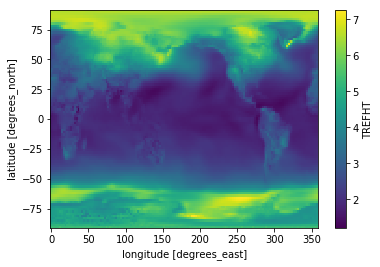

In [25]:
DeltaTa_slab.mean(dim='time').plot()

In [55]:
def make_map(field):
    '''input field should be a 2D xarray.DataArray on a lat/lon grid.
        Make a filled contour plot of the field, and a line plot of the zonal mean
    '''
    fig = plt.figure(figsize=(14,6))
    nrows = 10; ncols = 3
    mapax = plt.subplot2grid((nrows,ncols), (0,0), colspan=ncols-1, rowspan=nrows-1, projection=ccrs.Robinson())
    barax = plt.subplot2grid((nrows,ncols), (nrows-1,0), colspan=ncols-1)
    plotax = plt.subplot2grid((nrows,ncols), (0,ncols-1), rowspan=nrows-1)
    cx = mapax.contourf(field.lon, field.lat, field, transform=ccrs.PlateCarree())
    mapax.set_global(); mapax.coastlines();
    plt.colorbar(cx, cax=barax, orientation='horizontal')
    plotax.plot(field.mean(dim='lon'), field.lat)
    plotax.set_ylabel('Latitude')
    plotax.grid()
    return fig, (mapax, plotax, barax), cx

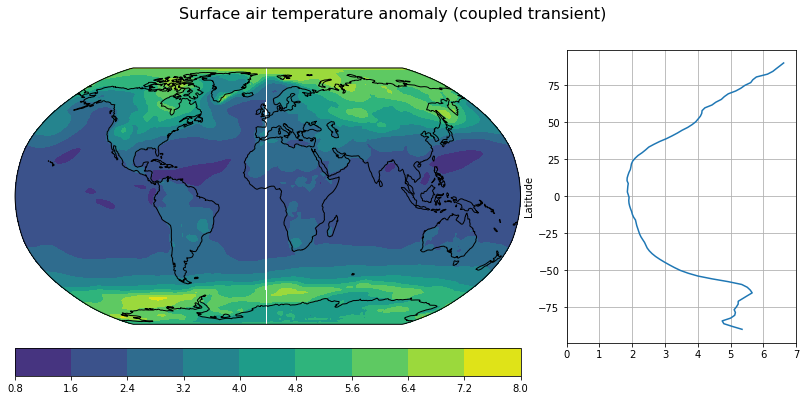

In [59]:
fig, axes, cx = make_map(DeltaTa_slab.mean(dim='time'))
fig.suptitle('Surface air temperature anomaly (coupled transient)', fontsize=16);
axes[1].set_xlim(0,7)  # ensure the line plots have same axes
cx.set_clim([0, 8])    # ensure the contour maps have the same color intervals

# fig, axes,cx  = make_map(DeltaTa_slab.mean(dim='time'))
# fig.suptitle('Surface air temperature anomaly (equilibrium SOM)', fontsize=16);
# axes[1].set_xlim(0,7)
# cx.set_clim([0, 8])

In [60]:
Tmap_cpl_2x = atm['cpl_CO2ramp'].TREFHT.isel(time=clim_slice_cpl).mean(dim='time')
Tmap_cpl_control = atm['cpl_control'].TREFHT.isel(time=clim_slice_cpl).mean(dim='time')
DeltaT_cpl = Tmap_cpl_2x - Tmap_cpl_control

Tmap_som_2x = atm['som_2xCO2'].TREFHT.isel(time=clim_slice_slab).mean(dim='time')
Tmap_som_control = atm['som_control'].TREFHT.isel(time=clim_slice_slab).mean(dim='time')
DeltaT_som = Tmap_som_2x - Tmap_som_control

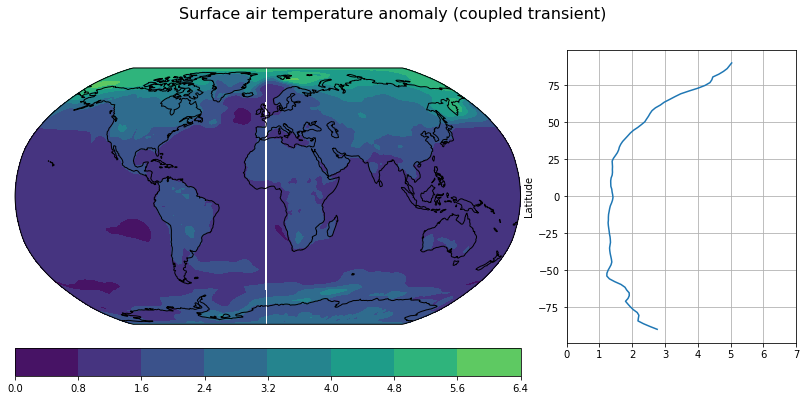

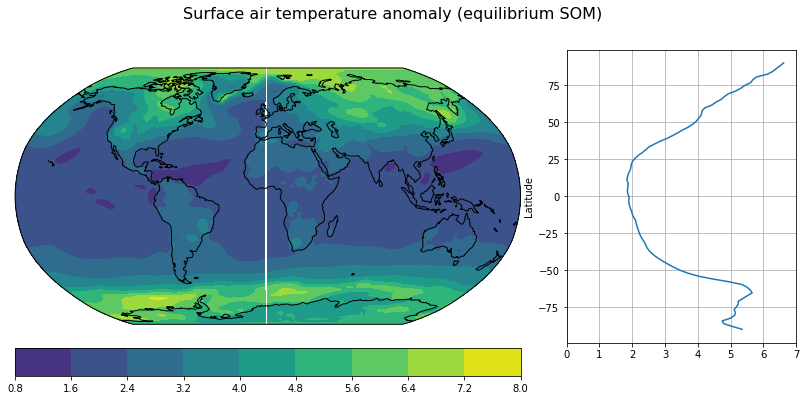

In [61]:
fig, axes, cx = make_map(DeltaT_cpl)
fig.suptitle('Surface air temperature anomaly (coupled transient)', fontsize=16);
axes[1].set_xlim(0,7)  # ensure the line plots have same axes
cx.set_clim([0, 8])    # ensure the contour maps have the same color intervals

fig, axes,cx  = make_map(DeltaT_som)
fig.suptitle('Surface air temperature anomaly (equilibrium SOM)', fontsize=16);
axes[1].set_xlim(0,7)
cx.set_clim([0, 8])

Text(0.5,0.98,'Places that warm more than the global mean in CESM simulations')

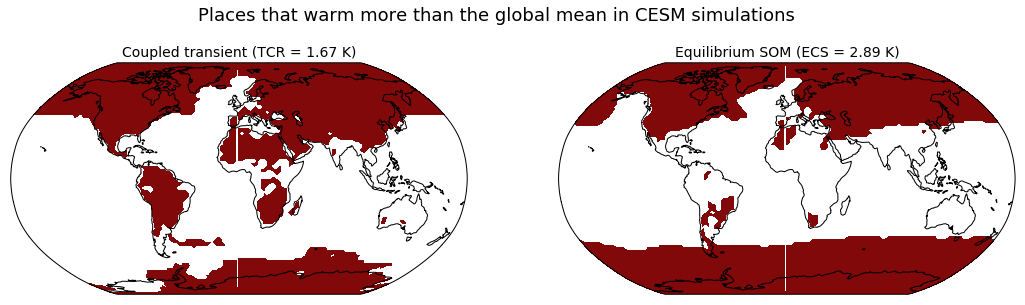

In [90]:
# Make a map like Gavin's...  places where warming is > global average
fig = plt.figure(figsize=(18,5))

ax1 = fig.add_subplot(1,2,1, projection=ccrs.Robinson())
ax1.contourf(DeltaT_cpl.lon, DeltaT_cpl.lat, 
             DeltaT_cpl.where(DeltaT_cpl>TCR), 
             levels=[0, 100], colors='#81090A',
             transform=ccrs.PlateCarree())
ax1.set_title('Coupled transient (TCR = {:.3} K)'.format(float(TCR)), fontsize=14)
ax2 = fig.add_subplot(1,2,2, projection=ccrs.Robinson())
ax2.contourf(DeltaT_som.lon, DeltaT_som.lat, 
             DeltaT_som.where(DeltaT_som>ECS), 
             levels=[0, 100], colors='#81090A',
             transform=ccrs.PlateCarree())
ax2.set_title('Equilibrium SOM (ECS = {:.3} K)'.format(float(ECS)), fontsize=14)

for ax in [ax1, ax2]:
    ax.set_global(); ax.coastlines();

fig.suptitle('Places that warm more than the global mean in CESM simulations', fontsize=18)

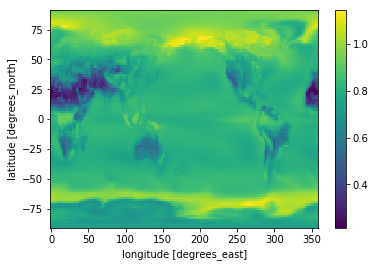

In [102]:
from climlab.utils.thermo import qsat
rh = atm['cpl_control'].QREFHT / qsat(atm['cpl_control'].TREFHT, (atm['cpl_control'].PS)/100)
rh.mean(dim='time').plot()

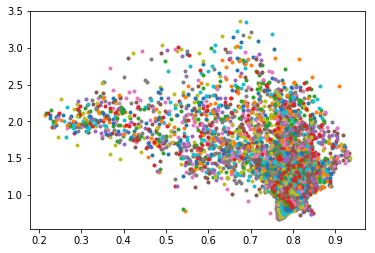

In [114]:
maxlat = 45.
plt.plot(rh.mean(dim='time').where(np.abs(rh.lat)<maxlat), DeltaT_cpl.where(np.abs(DeltaT_cpl.lat)<maxlat), '.');

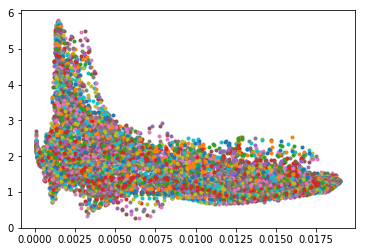

In [115]:
maxlat = 75.
plt.plot(atm['cpl_control'].QREFHT.mean(dim='time').where(np.abs(rh.lat)<maxlat), 
         DeltaT_cpl.where(np.abs(DeltaT_cpl.lat)<maxlat), '.');